# Example 11.1 (pag 494)

In [1]:
import statsmodels.api as sm
from scipy import stats
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

TABS_DIR = Path("../tests/data")

df = pd.read_csv(TABS_DIR / "tab_11_1.csv")
df.head(3)

,Reaction Time (min),Temperature (degC),Yield (%)
0,30,150,39.3
1,30,160,40.0
2,40,150,40.9


In [2]:
# Transform to coded variables
dfcod = df.copy()
for var in ['Reaction Time (min)','Temperature (degC)']:
    vmin, vmax = df[var].min(), df[var].max()
    vzer = (vmin+vmax)/2
    dfcod[var] = df[var].replace({vmin:-1, vzer:0, vmax:+1})
dfcod

,Reaction Time (min),Temperature (degC),Yield (%)
0,-1,-1,39.3
1,-1,1,40.0
2,1,-1,40.9
3,1,1,41.5
4,0,0,40.3
5,0,0,40.5
6,0,0,40.7
7,0,0,40.2
8,0,0,40.6


In [3]:
x = sm.add_constant(dfcod[['Reaction Time (min)','Temperature (degC)']]) # Add a column of ones to an array.
y = dfcod['Yield (%)']
model = sm.OLS(y,x)
res = model.fit()
res.summary()

/Users/danieleongari/opt/anaconda3/envs/pydoe/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Yield (%)   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     47.82
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           0.000206
Time:                        10:20:35   Log-Likelihood:                 4.9036
No. Observations:                   9   AIC:                            -3.807
Df Residuals:                       6   BIC:                            -3.216
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.4444      0.057    705.987      0.000      40.304      40.585
Reaction Time (min)     0.7750      0.086      9.019      0.000       0.565       0.985
Temperature (degC)      0.3250      0.086      3.782      0.009       0.115       0.535
==============================================================================
Omnibus:                        0.188   Durbin-Watson:                   2.850
Prob(Omnibus):                  0.910   Jarque-Bera (JB):                0.098
Skew:                           0.114   Prob(JB):                        0.952
Kurtosis:                       2.543   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

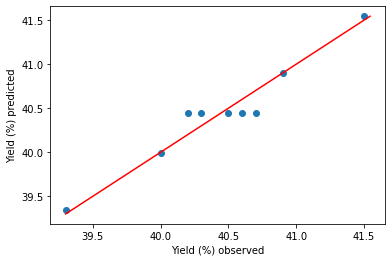

In [4]:
plt.scatter(y, res.predict())
alldata = list(y) + list(res.predict())
plt.plot([min(alldata), max(alldata)],[min(alldata), max(alldata)], color='red')
plt.xlabel(f'{y.name} observed')
plt.ylabel(f'{y.name} predicted')
plt.show()

In [5]:
# Hypothesis: non-null interaction
dfcod_blank = dfcod[(dfcod['Reaction Time (min)']==0) & (dfcod['Temperature (degC)']==0)] # center points
dfcod_treat = dfcod[(dfcod['Reaction Time (min)']!=0) & (dfcod['Temperature (degC)']!=0)] # factorial portion
sigma_cap_2 = dfcod_blank['Yield (%)'].var()
beta_cap_12 = dfcod_treat.product(axis=1).mean()
ss = dfcod_treat.product(axis=1).sum()**2/4
f0 = ss/sigma_cap_2
dof = len(dfcod_blank) - len(dfcod_treat)
dof_error = len(dfcod_blank) - 1
pval = stats.f(dof, dof_error).sf(f0)
print(f"P-Value: {pval:.4f} -> hypotesis", ["rejected", "accepted"][int(pval<0.05)])

P-Value: 0.8213 -> hypotesis rejected


In [6]:
# Hypothesis: second-order curvature (explained in Chap. 6.8)
dfcod_blank = dfcod[(dfcod['Reaction Time (min)']==0) & (dfcod['Temperature (degC)']==0)] # center points
dfcod_treat = dfcod[(dfcod['Reaction Time (min)']!=0) & (dfcod['Temperature (degC)']!=0)] # factorial portion
yf = dfcod_blank['Yield (%)'].mean()
yc = dfcod_treat['Yield (%)'].mean()
sigma_cap_2 = dfcod_blank['Yield (%)'].var()
ss = len(dfcod_blank)*len(dfcod_treat)*(yf-yc)**2/(len(dfcod_blank)+len(dfcod_treat))
f0 = ss/sigma_cap_2
dof = len(dfcod_blank) - len(dfcod_treat)
dof_error = len(dfcod_blank) - 1
pval = stats.f(dof, dof_error).sf(f0)
print(f"P-Value: {pval:.4f} -> hypotesis", ["rejected", "accepted"][int(pval<0.05)])

P-Value: 0.8137 -> hypotesis rejected


In [7]:
# Stepest gradient path (x1: Reaction Time, x2: Temperature)
delta_x1 = 1 # coded units
delta_x2 = delta_x1 * res.params['Temperature (degC)'] / res.params['Reaction Time (min)'] # coded units

# Convert to natural units
delta_x1 *= (df['Reaction Time (min)'].max() - df['Reaction Time (min)'].min())/((1)-(-1)) # min (Reaction Time)
delta_x2 *=  (df['Temperature (degC)'].max() - df['Temperature (degC)'].min())/((1)-(-1)) # degC (temperature)

origin = (df['Temperature (degC)'].values[-1], df['Reaction Time (min)'].values[-1])
for i in range(10):
    print(f"Step {i} - Time: {origin[1]+i*delta_x1:.1f} min, Temperature: {origin[0]+i*delta_x2:.1f} degC")

Step 0 - Time: 35.0 min, Temperature: 155.0 degC
Step 1 - Time: 40.0 min, Temperature: 157.1 degC
Step 2 - Time: 45.0 min, Temperature: 159.2 degC
Step 3 - Time: 50.0 min, Temperature: 161.3 degC
Step 4 - Time: 55.0 min, Temperature: 163.4 degC
Step 5 - Time: 60.0 min, Temperature: 165.5 degC
Step 6 - Time: 65.0 min, Temperature: 167.6 degC
Step 7 - Time: 70.0 min, Temperature: 169.7 degC
Step 8 - Time: 75.0 min, Temperature: 171.8 degC
Step 9 - Time: 80.0 min, Temperature: 173.9 degC


## Second part with new data

In [8]:
df = pd.read_csv(TABS_DIR / "tab_11_4.csv")
df.head(3)

,Reaction Time (min),Temperature (degC),Yield (%)
0,80,170,76.5
1,80,180,77.0
2,90,170,78.0


In [9]:
# Transform to coded variables
dfcod = df.copy()
for var in ['Reaction Time (min)','Temperature (degC)']:
    vmin, vmax = df[var].min(), df[var].max()
    vzer = (vmin+vmax)/2
    dfcod[var] = df[var].replace({vmin:-1, vzer:0, vmax:+1})
dfcod

,Reaction Time (min),Temperature (degC),Yield (%)
0,-1,-1,76.5
1,-1,1,77.0
2,1,-1,78.0
3,1,1,79.5
4,0,0,79.9
5,0,0,80.3
6,0,0,80.0
7,0,0,79.7
8,0,0,79.8


In [10]:
# Hypothesis: non-null interaction
dfcod_blank = dfcod[(dfcod['Reaction Time (min)']==0) & (dfcod['Temperature (degC)']==0)] # center points
dfcod_treat = dfcod[(dfcod['Reaction Time (min)']!=0) & (dfcod['Temperature (degC)']!=0)] # factorial portion
sigma_cap_2 = dfcod_blank['Yield (%)'].var()
beta_cap_12 = dfcod_treat.product(axis=1).mean()
ss = dfcod_treat.product(axis=1).sum()**2/4
f0 = ss/sigma_cap_2
dof = len(dfcod_blank) - len(dfcod_treat)
dof_error = len(dfcod_blank) - 1
pval = stats.f(dof, dof_error).sf(f0)
print(f"P-Value: {pval:.4f} -> hypotesis", ["rejected", "accepted"][int(pval<0.05)])

P-Value: 0.0956 -> hypotesis rejected


In [11]:
# Hypothesis: second-order curvature (explained in Chap. 6.8)
dfcod_blank = dfcod[(dfcod['Reaction Time (min)']==0) & (dfcod['Temperature (degC)']==0)] # center points
dfcod_treat = dfcod[(dfcod['Reaction Time (min)']!=0) & (dfcod['Temperature (degC)']!=0)] # factorial portion
yf = dfcod_blank['Yield (%)'].mean()
yc = dfcod_treat['Yield (%)'].mean()
sigma_cap_2 = dfcod_blank['Yield (%)'].var()
ss = len(dfcod_blank)*len(dfcod_treat)*(yf-yc)**2/(len(dfcod_blank)+len(dfcod_treat))
f0 = ss/sigma_cap_2
dof = len(dfcod_blank) - len(dfcod_treat)
dof_error = len(dfcod_blank) - 1
pval = stats.f(dof, dof_error).sf(f0)
print(f"P-Value: {pval:.4f} -> hypotesis", ["rejected", "accepted"][int(pval<0.05)])

P-Value: 0.0001 -> hypotesis accepted
